# Exploratory Data Analysis (EDA) for Credit Risk Model
This notebook explores the Xente dataset to uncover patterns, calculate RFM metrics, and guide feature engineering for the credit risk model. It includes data loading, summary statistics, visualizations, and insights.

### Import & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set plot style
sns.set(style='whitegrid')

# Load dataset
df = pd.read_csv('../data/raw/TrainingData.csv')
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
print('Dataset Shape:', df.shape)
print('\nData Info:')
print(df.info())
print('\nMissing Values:')
print(df.isnull().sum())
print('\nSummary Statistics:')
print(df.describe())


Dataset Shape: (95662, 16)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662 

### RFM Calculation

In [2]:
# Calculate RFM metrics
snapshot_date = df['TransactionStartTime'].max()
rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,
    'TransactionId': 'count',
    'Amount': 'sum'
}).rename(columns={
    'TransactionStartTime': 'Recency',
    'TransactionId': 'Frequency',
    'Amount': 'Monetary'
})
print('\nRFM Metrics:')
print(rfm.head())


RFM Metrics:
                 Recency  Frequency  Monetary
CustomerId                                   
CustomerId_1          83          1  -10000.0
CustomerId_10         83          1  -10000.0
CustomerId_1001       89          5   20000.0
CustomerId_1002       25         11    4225.0
CustomerId_1003       11          6   20000.0


### Distribution Plots

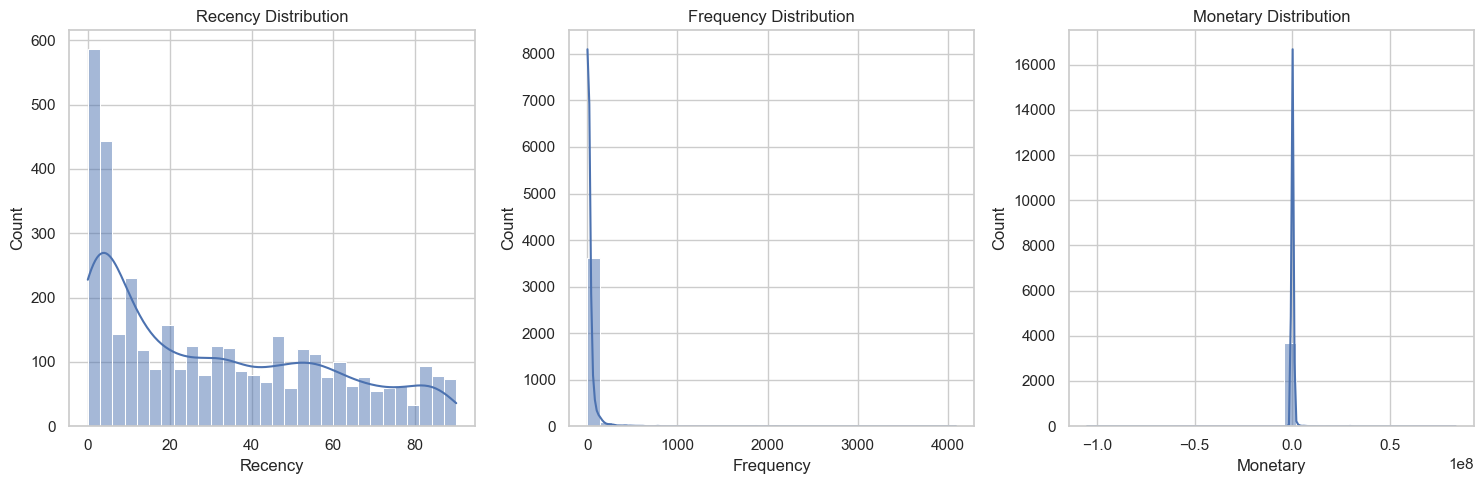

In [3]:
# Visualize distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.savefig('../reports/figures/rfm_distributions.png')
plt.show()

### Boxplots and Outlier Detection

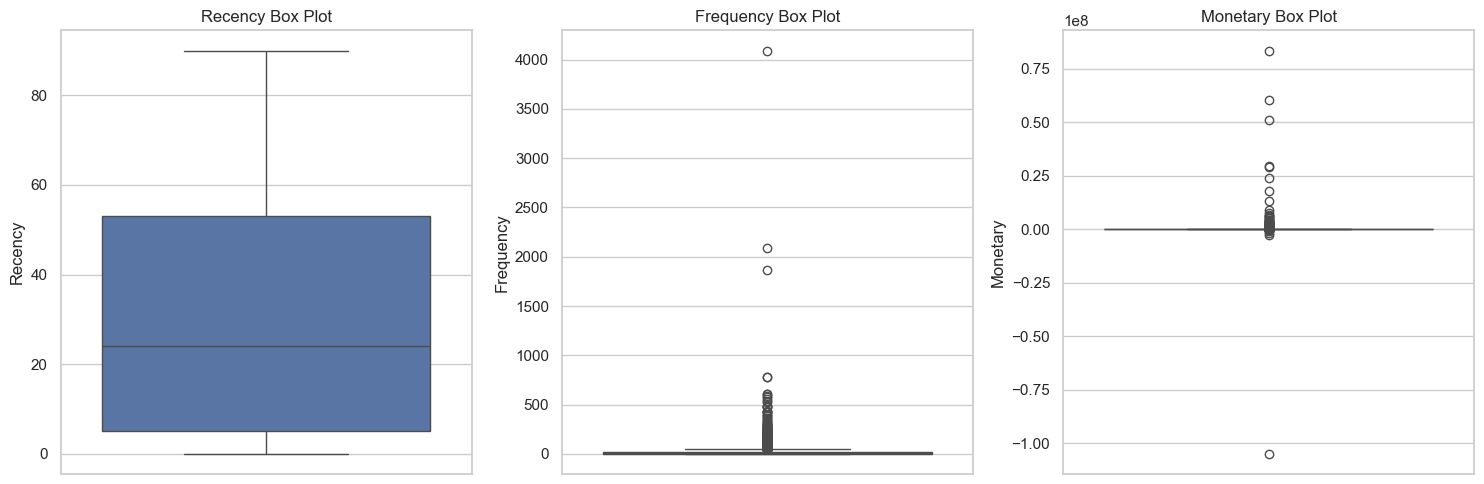


Monetary Outliers: 470


In [4]:
# Outlier detection
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=rfm['Recency'])
plt.title('Recency Box Plot')

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm['Frequency'])
plt.title('Frequency Box Plot')

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm['Monetary'])
plt.title('Monetary Box Plot')

plt.tight_layout()
plt.savefig('../reports/figures/rfm_boxplots.png')
plt.show()

# Calculate IQR for Monetary
Q1 = rfm['Monetary'].quantile(0.25)
Q3 = rfm['Monetary'].quantile(0.75)
IQR = Q3 - Q1
outliers = rfm[(rfm['Monetary'] < Q1 - 1.5 * IQR) | (rfm['Monetary'] > Q3 + 1.5 * IQR)]
print('\nMonetary Outliers:', len(outliers))

### Correlation & Pairplot

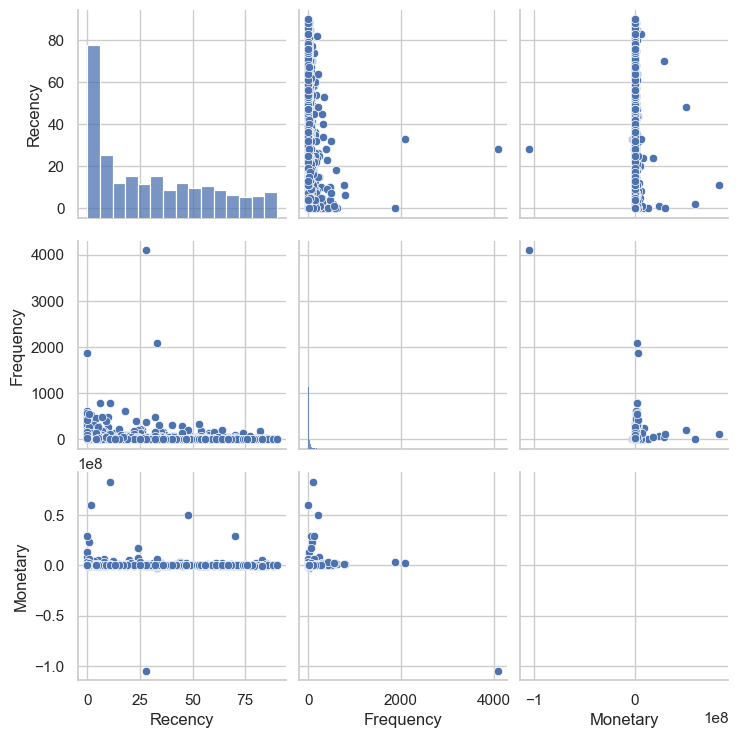


Correlation Matrix:
            Recency  Frequency  Monetary
Recency    1.000000  -0.153912 -0.028275
Frequency -0.153912   1.000000 -0.366095
Monetary  -0.028275  -0.366095  1.000000


In [5]:
# Correlation and pair plot
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.savefig('../reports/figures/rfm_pairplot.png')
plt.show()

print('\nCorrelation Matrix:')
print(rfm[['Recency', 'Frequency', 'Monetary']].corr())


### Categorical Features

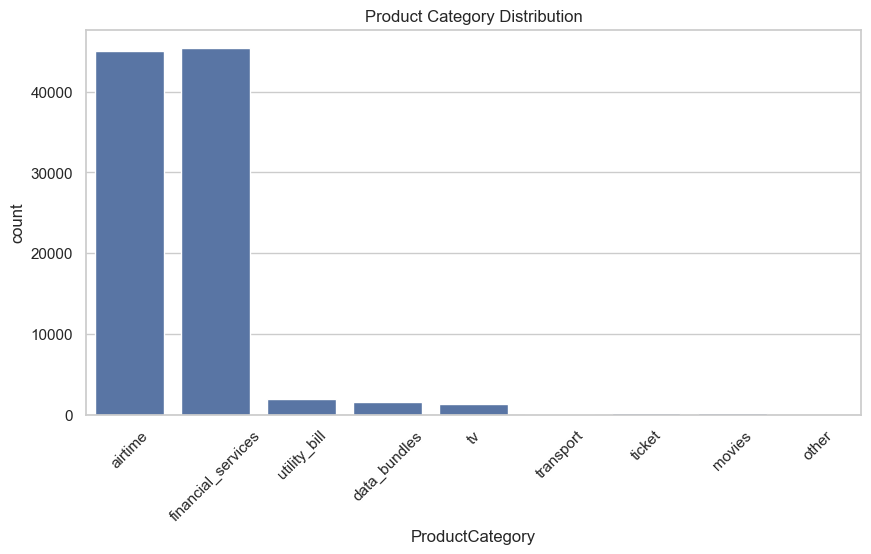

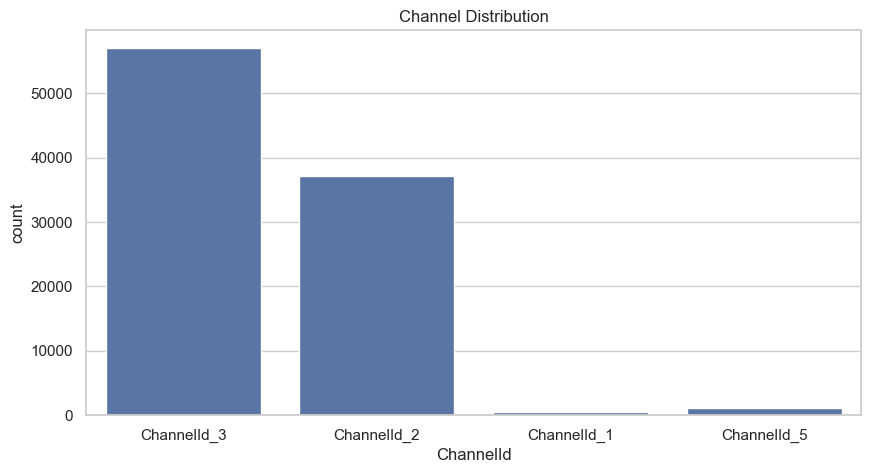

In [6]:
# Categorical feature analysis
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='ProductCategory')
plt.xticks(rotation=45)
plt.title('Product Category Distribution')
plt.savefig('../reports/figures/product_category_distribution.png')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='ChannelId')
plt.title('Channel Distribution')
plt.savefig('../reports/figures/channel_distribution.png')
plt.show()


### Clustering & Labeling High-Risk

In [7]:
# Proxy variable (initial clustering)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze clusters
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print('\nCluster Summary:')
print(cluster_summary)

# Assign high-risk label (lowest Monetary cluster)
high_risk_cluster = cluster_summary['Monetary'].idxmin()
rfm['is_high_risk'] = rfm['Cluster'].apply(lambda x: 1 if x == high_risk_cluster else 0)
print('\nHigh-Risk Customers:', rfm['is_high_risk'].sum())



Cluster Summary:
           Recency    Frequency      Monetary
Cluster                                      
0        60.859846     7.726699  8.172379e+04
1        28.000000  4091.000000 -1.049000e+08
2        11.716076    34.807692  2.726546e+05

High-Risk Customers: 1


## Insights

**Monetary Distribution is Extremely Right-Skewed**
- The histogram shows a sharp spike near zero with a long tail extending to very high values (up to ~100 million). This indicates that a small number of customers have extraordinarily high spending, which can dominate the scale and mislead models unless log-transformed or capped.

**High Frequency and Monetary Outliers Detected**

- Box plots reveal substantial outliers in both Frequency and Monetary features. Notably, 470 customers were flagged as outliers in Monetary alone. These outliers must be carefully handled—either through capping, transformation, or segmentation—to ensure robust model training.

**Recency is Skewed Toward Recent Transactions**

- The Recency histogram shows that many customers transacted very recently (low Recency values). This might imply ongoing engagement. However, the spread in the boxplot also indicates a decent mix of lapsed users, suggesting Recency can help differentiate risk profiles.

**Weak Correlation Among RFM Features**

- The pair plot and correlation matrix confirm minimal linear relationships between Recency, Frequency, and Monetary. For instance, Recency and Monetary show no strong correlation, implying each dimension adds unique value in customer segmentation or credit risk prediction.

**Clustering Opportunity is Strong Despite Skewness**
- Despite the skewed distributions, the visible groupings in the pair plots suggest clustering algorithms like K-Means (with scaling or transformation) can still extract meaningful customer segments, including a low-spending, low-frequency group likely to represent high-risk individuals.